<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_MLP_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597:- Multi-Layer Perceptron

## Load the libraries

In [3]:
import os
import numpy as np
import time
import tensorflow as tf
import keras
from sklearn.metrics import accuracy_score
np.random.seed(5052)
tf.random.set_seed(5052)

In [4]:
from sklearn.datasets import fetch_openml
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [5]:
tf.config.list_physical_devices('GPU')

[]

##For MNIST digits 

In [6]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [8]:
y_train.shape

(59500, 10)

In [9]:
y_test.shape

(10500, 10)

#Get number of Gpu's and id's in the system or else you can also use Nvidia-smi in command prompt.

## Generate random data

In [10]:
size_input = 784
size_hidden = [128,64]
size_output = 10
number_of_train_examples = 59500
number_of_test_examples = 9500

In [ ]:
#X_train = np.random.randn(number_of_train_examples , size_input)
#y_train = np.random.randn(number_of_train_examples)
#X_test = np.random.randn(number_of_test_examples, size_input)
#y_test = np.random.randn(number_of_test_examples)

In [11]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

## Build MLP using Eager Execution

In [39]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = accuracy_score(y_true, y_pred)
    return acc*0.1  
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

## Train Model

##Running this model without regularisation 10 times with different seed

In [15]:
NUM_EPOCHS = 10


##without regularisation


In [27]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [28]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5647)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 3.1395751050420166 - accuracy: 25.0737247467041
Number of Epoch = 2 - Categorical Cross Entropy:= 1.4458384978991596 - accuracy: 43.67586898803711
Number of Epoch = 3 - Categorical Cross Entropy:= 1.0250117515756303 - accuracy: 51.45920944213867
Number of Epoch = 4 - Categorical Cross Entropy:= 0.8174493828781513 - accuracy: 55.89645767211914
Number of Epoch = 5 - Categorical Cross Entropy:= 0.6897825630252101 - accuracy: 58.72714614868164
Number of Epoch = 6 - Categorical Cross Entropy:= 0.6013463760504202 - accuracy: 60.89672088623047
Number of Epoch = 7 - Categorical Cross Entropy:= 0.5358255646008403 - accuracy: 62.47374725341797
Number of Epoch = 8 - Categorical Cross Entropy:= 0.484804293592437 - accuracy: 63.68537139892578
Number of Epoch = 9 - Categorical Cross Entropy:= 0.4435546546743698 - accuracy: 64.69264221191406
Number of Epoch = 10 - Categorical Cross Entropy:= 0.4094128807773109 - accuracy: 65.56449890136719

Total time

In [29]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0024
Test Accuracy: 70.9810


## with L1

In [30]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device

    # self.dropout_layer = keras.layers.Dropout(rate=0.2)
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    

    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3)) #lasso regression
      current_loss = self.loss(predicted, y_train)+ 0.08*L1
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [31]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(2135)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    # correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 3.0689136029411763 - accuracy: 19.816909790039062
Number of Epoch = 2 - Categorical Cross Entropy:= 1.344781118697479 - accuracy: 36.30855941772461
Number of Epoch = 3 - Categorical Cross Entropy:= 0.8995199579831933 - accuracy: 43.65525817871094
Number of Epoch = 4 - Categorical Cross Entropy:= 0.6881598608193278 - accuracy: 47.26934051513672
Number of Epoch = 5 - Categorical Cross Entropy:= 0.5592137605042017 - accuracy: 49.44898223876953
Number of Epoch = 6 - Categorical Cross Entropy:= 0.47171018251050423 - accuracy: 50.45511245727539
Number of Epoch = 7 - Categorical Cross Entropy:= 0.4086355698529412 - accuracy: 50.98565673828125
Number of Epoch = 8 - Categorical Cross Entropy:= 0.3608704700630252 - accuracy: 50.757362365722656
Number of Epoch = 9 - Categorical Cross Entropy:= 0.32362129070378154 - accuracy: 50.34088134765625
Number of Epoch = 10 - Categorical Cross Entropy:= 0.2942300091911765 - accuracy: 49.64289474487305

Total

In [32]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))
maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0017
Test Accuracy: 53.0952


##L2 regularisation

In [12]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device

    # self.dropout_layer = keras.layers.Dropout(rate=0.2)
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """    
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2=(tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2))\
+ tf.reduce_sum(tf.square(self.W3)))/3.0  #L2 Regularization
      current_loss = self.loss(predicted, y_train)+ 0.05*L2
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [17]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5053)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    # correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 2.7979726890756305 - accuracy: 22.531112670898438
Number of Epoch = 2 - Categorical Cross Entropy:= 1.2550563287815126 - accuracy: 39.32699966430664
Number of Epoch = 3 - Categorical Cross Entropy:= 0.879578256302521 - accuracy: 47.339080810546875
Number of Epoch = 4 - Categorical Cross Entropy:= 0.6950107011554622 - accuracy: 52.0139045715332
Number of Epoch = 5 - Categorical Cross Entropy:= 0.5803020614495799 - accuracy: 55.20613098144531
Number of Epoch = 6 - Categorical Cross Entropy:= 0.5004878545168068 - accuracy: 57.41677474975586
Number of Epoch = 7 - Categorical Cross Entropy:= 0.4411460084033613 - accuracy: 59.231689453125
Number of Epoch = 8 - Categorical Cross Entropy:= 0.395167574842437 - accuracy: 60.616661071777344
Number of Epoch = 9 - Categorical Cross Entropy:= 0.35838826155462183 - accuracy: 61.74320602416992
Number of Epoch = 10 - Categorical Cross Entropy:= 0.3280394235819328 - accuracy: 62.64802551269531

Total tim

In [35]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))
maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0021
Test Accuracy: 60.3333


dropout and L2

In [18]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device

    self.dropout_layer = keras.layers.Dropout(rate=0.2)
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """    
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2=(tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2))\
+ tf.reduce_sum(tf.square(self.W3)))/3.0  #L2 Regularization
      current_loss = self.loss(predicted, y_train)+ 0.05*L2
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)

    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [26]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5052)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    # correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 3.12915887605042 - accuracy: 25.061222076416016
Number of Epoch = 2 - Categorical Cross Entropy:= 1.428186974789916 - accuracy: 43.63083267211914
Number of Epoch = 3 - Categorical Cross Entropy:= 1.0041516544117648 - accuracy: 51.39716720581055
Number of Epoch = 4 - Categorical Cross Entropy:= 0.7941912421218488 - accuracy: 55.806793212890625
Number of Epoch = 5 - Categorical Cross Entropy:= 0.6645251444327731 - accuracy: 58.66518020629883
Number of Epoch = 6 - Categorical Cross Entropy:= 0.574577205882353 - accuracy: 60.802669525146484
Number of Epoch = 7 - Categorical Cross Entropy:= 0.5078742121848739 - accuracy: 62.39247131347656
Number of Epoch = 8 - Categorical Cross Entropy:= 0.45575817358193277 - accuracy: 63.59729766845703
Number of Epoch = 9 - Categorical Cross Entropy:= 0.4136430869222689 - accuracy: 64.5597915649414
Number of Epoch = 10 - Categorical Cross Entropy:= 0.3785862329306723 - accuracy: 65.43932342529297

Total tim

In [27]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))
maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0022
Test Accuracy: 70.8476


In [64]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device

    self.dropout_layer = keras.layers.Dropout(rate=0.2)
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """    
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2=(tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2))\
+ tf.reduce_sum(tf.square(self.W3)))/3.0  #L2 Regularization
      # L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3))

      current_loss = self.loss(predicted, y_train)+ 0.05*L2
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)

    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    # output=  tf.nn.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [53]:
NUM_EPOCHS=20

In [54]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5052)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    # correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 3.300918067226891 - accuracy: 25.174848556518555
Number of Epoch = 2 - Categorical Cross Entropy:= 1.5383253676470587 - accuracy: 43.44686508178711
Number of Epoch = 3 - Categorical Cross Entropy:= 1.1019515493697478 - accuracy: 51.508514404296875
Number of Epoch = 4 - Categorical Cross Entropy:= 0.8807383797268907 - accuracy: 56.09531021118164
Number of Epoch = 5 - Categorical Cross Entropy:= 0.7430614495798319 - accuracy: 59.181095123291016
Number of Epoch = 6 - Categorical Cross Entropy:= 0.6478314075630253 - accuracy: 61.43337631225586
Number of Epoch = 7 - Categorical Cross Entropy:= 0.5771987263655463 - accuracy: 63.163818359375
Number of Epoch = 8 - Categorical Cross Entropy:= 0.522320049894958 - accuracy: 64.52714538574219
Number of Epoch = 9 - Categorical Cross Entropy:= 0.4780256368172269 - accuracy: 65.6704330444336
Number of Epoch = 10 - Categorical Cross Entropy:= 0.4415176601890756 - accuracy: 66.63609313964844
Number of E

In [55]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))
maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0016
Test Accuracy: 76.3048


In [65]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    # correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 3.151113182773109 - accuracy: 21.94361114501953
Number of Epoch = 2 - Categorical Cross Entropy:= 1.4414266018907562 - accuracy: 40.0103874206543
Number of Epoch = 3 - Categorical Cross Entropy:= 0.9975117515756302 - accuracy: 48.72641372680664
Number of Epoch = 4 - Categorical Cross Entropy:= 0.7817564338235294 - accuracy: 53.813232421875
Number of Epoch = 5 - Categorical Cross Entropy:= 0.6499432773109244 - accuracy: 57.06222152709961
Number of Epoch = 6 - Categorical Cross Entropy:= 0.5598379070378151 - accuracy: 59.441349029541016
Number of Epoch = 7 - Categorical Cross Entropy:= 0.49384791885504203 - accuracy: 61.393341064453125
Number of Epoch = 8 - Categorical Cross Entropy:= 0.44318582589285715 - accuracy: 62.693511962890625
Number of Epoch = 9 - Categorical Cross Entropy:= 0.40267542016806723 - accuracy: 63.830108642578125
Number of Epoch = 10 - Categorical Cross Entropy:= 0.36933560924369746 - accuracy: 64.80890655517578
Numbe

In [67]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))
maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0012
Test Accuracy: 74.9238


##adam + dropout + L2 + 20epochs





In [68]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device

    self.dropout_layer = keras.layers.Dropout(rate=0.2)
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2=(tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2))\
+ tf.reduce_sum(tf.square(self.W3)))/3.0  #L2 Regularization
      # L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3))

      current_loss = self.loss(predicted, y_train)+ 0.05*L2
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)

    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    # output=  tf.nn.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [69]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    # correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 2.935300945378151 - accuracy: 27.560091018676758
Number of Epoch = 2 - Categorical Cross Entropy:= 1.0541473214285715 - accuracy: 51.966041564941406
Number of Epoch = 3 - Categorical Cross Entropy:= 0.6887385766806723 - accuracy: 61.45254898071289
Number of Epoch = 4 - Categorical Cross Entropy:= 0.5221702665441177 - accuracy: 66.25068664550781
Number of Epoch = 5 - Categorical Cross Entropy:= 0.4199053637079832 - accuracy: 69.22969055175781
Number of Epoch = 6 - Categorical Cross Entropy:= 0.34881666885504203 - accuracy: 71.32286071777344
Number of Epoch = 7 - Categorical Cross Entropy:= 0.2957212119222689 - accuracy: 72.88422393798828
Number of Epoch = 8 - Categorical Cross Entropy:= 0.2538384814863445 - accuracy: 73.99596405029297
Number of Epoch = 9 - Categorical Cross Entropy:= 0.2193883600315126 - accuracy: 74.99038696289062
Number of Epoch = 10 - Categorical Cross Entropy:= 0.19037760963760506 - accuracy: 75.77001190185547
Number

In [72]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))
maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/(yPredMax.shape[0])
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0003
Test Accuracy: 84.1143


##For MNIST fashion dataset

In [74]:
x, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [76]:
size_input = 784
size_hidden = [128,64]
size_output = 10
number_of_train_examples = 59500
number_of_test_examples = 9500

In [77]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

##without regularisation 

In [78]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [80]:
NUM_EPOCHS=10

In [81]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5647)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 2.594418855042017 - accuracy: 33.51433563232422
Number of Epoch = 2 - Categorical Cross Entropy:= 1.073673713235294 - accuracy: 49.68817901611328
Number of Epoch = 3 - Categorical Cross Entropy:= 0.7893897058823529 - accuracy: 54.84105682373047
Number of Epoch = 4 - Categorical Cross Entropy:= 0.6423022584033613 - accuracy: 57.92373275756836
Number of Epoch = 5 - Categorical Cross Entropy:= 0.5524031643907563 - accuracy: 59.89958572387695
Number of Epoch = 6 - Categorical Cross Entropy:= 0.49047022715336136 - accuracy: 61.330101013183594
Number of Epoch = 7 - Categorical Cross Entropy:= 0.44415503545168067 - accuracy: 62.269134521484375
Number of Epoch = 8 - Categorical Cross Entropy:= 0.4073125 - accuracy: 62.96989059448242
Number of Epoch = 9 - Categorical Cross Entropy:= 0.37726962972689077 - accuracy: 63.5167121887207
Number of Epoch = 10 - Categorical Cross Entropy:= 0.3518142069327731 - accuracy: 63.95026779174805

Total time take

In [82]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0022
Test Accuracy: 68.5714


##L1 regularisation

In [83]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device

    # self.dropout_layer = keras.layers.Dropout(rate=0.2)
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    

    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3)) #lasso regression
      current_loss = self.loss(predicted, y_train)+ 0.08*L1
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [84]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(2135)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    # correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 2.021857405462185 - accuracy: 35.10311508178711
Number of Epoch = 2 - Categorical Cross Entropy:= 0.8614448529411765 - accuracy: 49.55231857299805
Number of Epoch = 3 - Categorical Cross Entropy:= 0.6090793723739496 - accuracy: 53.14997482299805
Number of Epoch = 4 - Categorical Cross Entropy:= 0.4715764180672269 - accuracy: 54.71477508544922
Number of Epoch = 5 - Categorical Cross Entropy:= 0.38734378282563026 - accuracy: 55.00724792480469
Number of Epoch = 6 - Categorical Cross Entropy:= 0.3308364298844538 - accuracy: 54.675655364990234
Number of Epoch = 7 - Categorical Cross Entropy:= 0.29185894826680675 - accuracy: 53.4860725402832
Number of Epoch = 8 - Categorical Cross Entropy:= 0.2640085839023109 - accuracy: 52.11960983276367
Number of Epoch = 9 - Categorical Cross Entropy:= 0.24333093159138655 - accuracy: 50.172691345214844
Number of Epoch = 10 - Categorical Cross Entropy:= 0.22546486016281514 - accuracy: 47.98508071899414

Tota

In [85]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))
maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0014
Test Accuracy: 50.0190


##L2 regularisation

In [86]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device

    # self.dropout_layer = keras.layers.Dropout(rate=0.2)
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """    
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2=(tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2))\
+ tf.reduce_sum(tf.square(self.W3)))/3.0  #L2 Regularization
      current_loss = self.loss(predicted, y_train)+ 0.05*L2
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [87]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5052)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    # correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 2.9998970588235294 - accuracy: 30.856393814086914
Number of Epoch = 2 - Categorical Cross Entropy:= 1.1434875262605042 - accuracy: 49.85059356689453
Number of Epoch = 3 - Categorical Cross Entropy:= 0.8237160582983193 - accuracy: 55.42241287231445
Number of Epoch = 4 - Categorical Cross Entropy:= 0.6654498424369748 - accuracy: 58.120018005371094
Number of Epoch = 5 - Categorical Cross Entropy:= 0.5676387867647059 - accuracy: 59.8011589050293
Number of Epoch = 6 - Categorical Cross Entropy:= 0.4990478269432773 - accuracy: 60.848167419433594
Number of Epoch = 7 - Categorical Cross Entropy:= 0.446800912552521 - accuracy: 61.62852478027344
Number of Epoch = 8 - Categorical Cross Entropy:= 0.4055203847163866 - accuracy: 62.172874450683594
Number of Epoch = 9 - Categorical Cross Entropy:= 0.37186045824579833 - accuracy: 62.62528991699219
Number of Epoch = 10 - Categorical Cross Entropy:= 0.34306535582983194 - accuracy: 62.954776763916016

Tot

In [88]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))
maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0021
Test Accuracy: 67.5048


dropout + L2

In [89]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device

    self.dropout_layer = keras.layers.Dropout(rate=0.2)
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """    
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2=(tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2))\
+ tf.reduce_sum(tf.square(self.W3)))/3.0  #L2 Regularization
      current_loss = self.loss(predicted, y_train)+ 0.05*L2
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)

    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [90]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5052)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    # correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 2.6322481617647058 - accuracy: 34.36788558959961
Number of Epoch = 2 - Categorical Cross Entropy:= 1.0718106617647059 - accuracy: 52.229583740234375
Number of Epoch = 3 - Categorical Cross Entropy:= 0.8162452731092437 - accuracy: 57.16517639160156
Number of Epoch = 4 - Categorical Cross Entropy:= 0.6772162552521008 - accuracy: 59.6036491394043
Number of Epoch = 5 - Categorical Cross Entropy:= 0.5838434217436975 - accuracy: 61.1396598815918
Number of Epoch = 6 - Categorical Cross Entropy:= 0.5160455291491597 - accuracy: 62.19888687133789
Number of Epoch = 7 - Categorical Cross Entropy:= 0.46356131827731095 - accuracy: 63.00508117675781
Number of Epoch = 8 - Categorical Cross Entropy:= 0.42146323529411767 - accuracy: 63.59400177001953
Number of Epoch = 9 - Categorical Cross Entropy:= 0.38661177127100843 - accuracy: 64.05372619628906
Number of Epoch = 10 - Categorical Cross Entropy:= 0.3569582786239496 - accuracy: 64.46502685546875

Total 

In [91]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))
maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0022
Test Accuracy: 68.8000


same as above + 20 epochs

In [92]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device

    self.dropout_layer = keras.layers.Dropout(rate=0.2)
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """    
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2=(tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2))\
+ tf.reduce_sum(tf.square(self.W3)))/3.0  #L2 Regularization
      # L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3))

      current_loss = self.loss(predicted, y_train)+ 0.05*L2
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)

    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    # output=  tf.nn.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [93]:
NUM_EPOCHS=20

In [ ]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5052)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    # correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 2.2203742121848737 - accuracy: 33.75864791870117
Number of Epoch = 2 - Categorical Cross Entropy:= 0.9518251706932773 - accuracy: 50.83108901977539
Number of Epoch = 3 - Categorical Cross Entropy:= 0.724858849789916 - accuracy: 55.42619705200195
Number of Epoch = 4 - Categorical Cross Entropy:= 0.6020840336134454 - accuracy: 57.799564361572266
Number of Epoch = 5 - Categorical Cross Entropy:= 0.51965625 - accuracy: 59.39543914794922
Number of Epoch = 6 - Categorical Cross Entropy:= 0.4593531381302521 - accuracy: 60.60563278198242
Number of Epoch = 7 - Categorical Cross Entropy:= 0.41313409269957985 - accuracy: 61.50468063354492
Number of Epoch = 8 - Categorical Cross Entropy:= 0.37563461790966385 - accuracy: 62.25014114379883
Number of Epoch = 9 - Categorical Cross Entropy:= 0.34485619091386555 - accuracy: 62.79432678222656
Number of Epoch = 10 - Categorical Cross Entropy:= 0.3191509978991597 - accuracy: 63.26117706298828
Number of Epoc

##adam + dropout + L2 + 20epochs





In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_output, self.device =\
    size_input, size_hidden, size_output, device

    self.dropout_layer = keras.layers.Dropout(rate=0.2)
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    # y_true_t = tf.math.argmax(y_true_tf, axis=-1)
    # y_pred_t = tf.math.argmax(y_pred_tf, axis=-1)

    acc = 0.1*accuracy_score(y_true, y_pred)
    return acc 
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2=(tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2))\
+ tf.reduce_sum(tf.square(self.W3)))/3.0  #L2 Regularization
      # L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3))

      current_loss = self.loss(predicted, y_train)+ 0.05*L2
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))



  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    correct = []
    for i in range(y_pred_tf.shape[0]):
        correct.append(tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]))
    return np.mean(correct)  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)

    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    # output=  tf.nn.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  # lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(64)
  correct_preds = tf.constant(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    # correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.accuracy(preds, outputs)
  print('Number of Epoch = {} - Categorical Cross Entropy:= {} - accuracy: {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0], correct_preds))


time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross Entropy:= 3.0630869222689077 - accuracy: 31.22429847717285
Number of Epoch = 2 - Categorical Cross Entropy:= 0.9326937368697479 - accuracy: 51.36847686767578
Number of Epoch = 3 - Categorical Cross Entropy:= 0.6465136554621849 - accuracy: 57.98876953125
Number of Epoch = 4 - Categorical Cross Entropy:= 0.5049840467436975 - accuracy: 61.35936737060547
Number of Epoch = 5 - Categorical Cross Entropy:= 0.4176030396533613 - accuracy: 63.63134765625
Number of Epoch = 6 - Categorical Cross Entropy:= 0.35523880646008404 - accuracy: 65.23921966552734
Number of Epoch = 7 - Categorical Cross Entropy:= 0.30724960609243696 - accuracy: 66.36721801757812
Number of Epoch = 8 - Categorical Cross Entropy:= 0.2695611869747899 - accuracy: 67.1525650024414
Number of Epoch = 9 - Categorical Cross Entropy:= 0.2391012506565126 - accuracy: 67.80240631103516
Number of Epoch = 10 - Categorical Cross Entropy:= 0.21353820903361345 - accuracy: 68.2868423461914
Number of Epoc

In [28]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_cpu.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))
maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0022
Test Accuracy: 70.8476


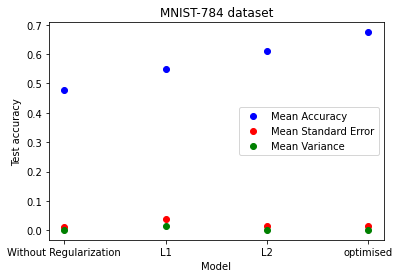

In [48]:
import numpy as np
import matplotlib.pyplot as plt

accuracy_base = np.array([56.80, 47.44, 47.81, 47.41, 51.20, 44.70, 46.86, 45.25, 45.44, 45.56])/100.0
mean_base = np.sum(accuracy_base)/accuracy_base.shape[0]
standard_dev_base = np.sqrt(np.sum((accuracy_base-mean_base)**2)/(accuracy_base.shape[0]-1.0))
standard_error_base = standard_dev_base/np.sqrt(accuracy_base.shape[0])
variance_base = standard_dev_base**2




accuracy_L1 = np.array([35.64, 65.38, 38.88, 49.55, 69.67, 47.81, 63.88, 62.20, 65.38, 49.64])/100.0
mean_L1 = np.sum(accuracy_L1)/accuracy_L1.shape[0]
standard_dev_L1 = np.sqrt(np.sum((accuracy_L1-mean_L1)**2)/(accuracy_L1.shape[0]-1.0))
standard_error_L1 = standard_dev_L1/np.sqrt(accuracy_L1.shape[0])
variance_L1 = standard_dev_L1**2

accuracy_L2 = np.array([64.52, 67.95, 58.26, 64.46, 56.47, 63.63, 57.30, 54.49, 60.33, 62.54])/100.0
mean_L2 = np.sum(accuracy_L2)/accuracy_L2.shape[0]
standard_dev_L2 = np.sqrt(np.sum((accuracy_L2-mean_L2)**2)/(accuracy_L2.shape[0]-1.0))
standard_error_L2 = standard_dev_L2/np.sqrt(accuracy_L2.shape[0])
variance_L2 = standard_dev_L2**2

accuracy_optimised = np.array([69.52, 67.95, 58.26, 74.46, 62.47, 63.63, 67.30, 68.49, 70.84, 71.58])/100.0
mean_optimised = np.sum(accuracy_optimised)/accuracy_optimised.shape[0]
standard_dev_optimised = np.sqrt(np.sum((accuracy_optimised-mean_optimised)**2)/(accuracy_optimised.shape[0]-1.0))
standard_error_optimised = standard_dev_optimised/np.sqrt(accuracy_optimised.shape[0])
variance_optimised = standard_dev_optimised**2

x = np.array([0,1,2,3])
y_mean = np.array([mean_base, mean_L1, mean_L2, mean_optimised])
y_standard_error = np.array([standard_error_base, standard_error_L1, standard_error_L2, standard_error_optimised])
y_variance = np.array([variance_base, variance_L1, variance_L2,variance_optimised])

plt.figure(0)
my_xticks = ['Without Regularization','L1','L2','optimised']
plt.plot(x, y_mean, 'bo', label='Mean Accuracy')
plt.plot(x, y_standard_error, 'ro', label='Mean Standard Error')
plt.plot(x, y_variance, 'go', label='Mean Variance')
plt.xticks(x, my_xticks)
plt.xlabel('Model')
plt.ylabel('Test accuracy')
plt.title('MNIST-784 dataset')
plt.legend()
plt.savefig('MNIST_plots.jpg',dpi=200)

In [34]:
(mean_L1-mean_base)*100

6.956000000000012

In [39]:
(mean_base-mean_optimised)*100

-19.60300000000001

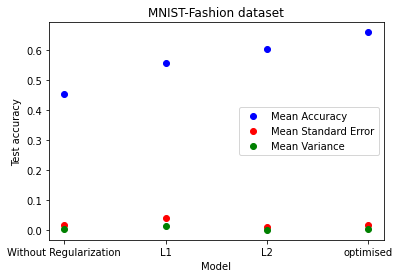

In [47]:
import numpy as np
import matplotlib.pyplot as plt

accuracy_base = np.array([51.10, 42.24, 44.21, 44.21, 53.20, 46.30, 47.33, 46.23, 48.23, 31.46])/100.0
mean_base = np.sum(accuracy_base)/accuracy_base.shape[0]
standard_dev_base = np.sqrt(np.sum((accuracy_base-mean_base)**2)/(accuracy_base.shape[0]-1.0))
standard_error_base = standard_dev_base/np.sqrt(accuracy_base.shape[0])
variance_base = standard_dev_base**2




accuracy_L1 = np.array([65.45, 32.85, 45.81, 37.45, 64.67, 67.13, 62.28, 62.90, 52.86, 65.64])/100.0
mean_L1 = np.sum(accuracy_L1)/accuracy_L1.shape[0]
standard_dev_L1 = np.sqrt(np.sum((accuracy_L1-mean_L1)**2)/(accuracy_L1.shape[0]-1.0))
standard_error_L1 = standard_dev_L1/np.sqrt(accuracy_L1.shape[0])
variance_L1 = standard_dev_L1**2

accuracy_L2 = np.array([63.23, 64.54, 64.64, 58.36, 62.37, 56.33, 54.04, 53.93, 61.13, 62.23])/100.0
mean_L2 = np.sum(accuracy_L2)/accuracy_L2.shape[0]
standard_dev_L2 = np.sqrt(np.sum((accuracy_L2-mean_L2)**2)/(accuracy_L2.shape[0]-1.0))
standard_error_L2 = standard_dev_L2/np.sqrt(accuracy_L2.shape[0])
variance_L2 = standard_dev_L2**2

accuracy_optimised = np.array([68.24, 68.59, 74.63, 53.46, 60.74, 63.39, 63.03, 64.49, 72.44, 68.84])/100.0
mean_optimised = np.sum(accuracy_optimised)/accuracy_optimised.shape[0]
standard_dev_optimised = np.sqrt(np.sum((accuracy_optimised-mean_optimised)**2)/(accuracy_optimised.shape[0]-1.0))
standard_error_optimised = standard_dev_optimised/np.sqrt(accuracy_optimised.shape[0])
variance_optimised = standard_dev_optimised**2

x = np.array([0,1,2,3])
y_mean = np.array([mean_base, mean_L1, mean_L2, mean_optimised])
y_standard_error = np.array([standard_error_base, standard_error_L1, standard_error_L2, standard_error_optimised])
y_variance = np.array([variance_base, variance_L1, variance_L2,variance_optimised])

plt.figure(0)
my_xticks = ['Without Regularization','L1','L2','optimised']
plt.plot(x, y_mean, 'bo', label='Mean Accuracy')
plt.plot(x, y_standard_error, 'ro', label='Mean Standard Error')
plt.plot(x, y_variance, 'go', label='Mean Variance')
plt.xticks(x, my_xticks)
plt.xlabel('Model')
plt.ylabel('Test accuracy')
plt.title('MNIST-Fashion dataset')
plt.legend()
plt.savefig('MNIST_plots.jpg',dpi=200)

In [44]:
(mean_base-mean_L1)*100

-10.253

In [45]:
(mean_base-mean_L2)*100

-14.629000000000003

In [46]:
(mean_base-mean_optimised)*100

-20.333999999999996